In [1]:
import seaborn as sns
from pyspark import SparkContext
from pyspark.sql import SparkSession

In [2]:
ss = SparkSession.Builder() \
     .appName("articles") \
     .master("spark://spark-master:7077") \
     .getOrCreate()

In [3]:
pip install pyvi

Note: you may need to restart the kernel to use updated packages.


In [4]:
df = ss.read.parquet("hdfs://namenode:9000/data/articles.parquet")

In [5]:
df.show()

+--------------------+--------------------+--------------------+--------------------+--------------+------------+--------------------+--------------------+--------------------+--------------------+--------+
|                  id|               title|                sapo|                 url|        source|pega_cate_id|         title_token|          sapo_token|       content_token|           all_token|   label|
+--------------------+--------------------+--------------------+--------------------+--------------+------------+--------------------+--------------------+--------------------+--------------------+--------+
|6.366651292038185E17|Anh phát hiện 39 ...|Ngày 23/10, cảnh ...|http://vnmedia.vn...|    vnmedia.vn|         102|Anh phát_hiện 39 ...|Ngày 23/10 , cảnh...|Theo cảnh_sát địa...|anh phát_hiện    ...|Thế giới|
|6.368640877043630...|Phát hiện két sắt...|Theo TASS ngày 23...|http://congan.com...| congan.com.vn|         102|Phát_hiện két sắt...|( CAO ) Theo TASS...|Theo điều_tra ban

In [6]:
df_new = df.drop('id', 
                'title', 
                'sapo',
                'url',
                'source',
                'title_token',
                'sapo_token',
                'content_token')

In [7]:
df_new = df_new.dropna()

In [8]:
df_new.show(5)

+------------+--------------------+--------+
|pega_cate_id|           all_token|   label|
+------------+--------------------+--------+
|         102|anh phát_hiện    ...|Thế giới|
|         102|phát_hiện két sắt...|Thế giới|
|         102|máy_bay rơi ở mex...|Thế giới|
|         102|hình_ảnh đệ nhất ...|Thế giới|
|         102|thủ_lĩnh cao nhất...|Thế giới|
+------------+--------------------+--------+
only showing top 5 rows



**Visualize data**

DataFrame[label: string, count: bigint]


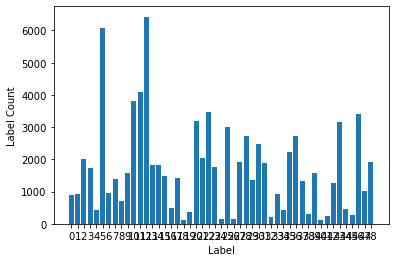

In [10]:

import numpy as np
import matplotlib.pyplot as plt
print(df.groupBy('label').count())
l = df.groupBy('label').count().collect()
x = list(zip(*l))[0]
y = list(zip(*l))[1]
x_pos = np.arange(len(x)) 
# slope, intercept = np.polyfit(x_pos, y, 1)
plt.bar(x_pos, y,align='center')
plt.xticks(x_pos) 
plt.ylabel('Label Count')
plt.xlabel('Label')
plt.show()

**Tokenize text in all_token columns**

In [8]:
from pyspark.ml.feature import Tokenizer, CountVectorizer
tkn = Tokenizer().setInputCol("all_token").setOutputCol("content_tokenized")
train_df = tkn.transform(df_new)
# train_df = tokenized.drop('title_token', 'sapo_token', 'content_token')

In [9]:
train_df.show(5)

+------------+--------------------+--------+--------------------+
|pega_cate_id|           all_token|   label|   content_tokenized|
+------------+--------------------+--------+--------------------+
|         102|anh phát_hiện    ...|Thế giới|[anh, phát_hiện, ...|
|         102|phát_hiện két sắt...|Thế giới|[phát_hiện, két, ...|
|         102|máy_bay rơi ở mex...|Thế giới|[máy_bay, rơi, ở,...|
|         102|hình_ảnh đệ nhất ...|Thế giới|[hình_ảnh, đệ, nh...|
|         102|thủ_lĩnh cao nhất...|Thế giới|[thủ_lĩnh, cao, n...|
+------------+--------------------+--------+--------------------+
only showing top 5 rows



**TF-IDF**

In [10]:
from pyspark.ml.feature import HashingTF, IDF
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, StringIndexer
from pyspark.ml import Pipeline

In [11]:
label_stringIdx = StringIndexer(inputCol = "label", outputCol = "label_id")
hashingTF = HashingTF(inputCol="content_tokenized", outputCol="rawFeatures", numFeatures=10000)
idf = IDF(inputCol="rawFeatures", outputCol="features", minDocFreq=5) #minDocFreq: remove sparse terms
pipeline = Pipeline(stages=[hashingTF, idf, label_stringIdx])
pipelineFit = pipeline.fit(train_df)
dataset = pipelineFit.transform(train_df)

In [12]:
dataset = dataset.withColumnRenamed("label", "label_name")
dataset = dataset.withColumnRenamed("label_id", "label")


In [13]:
dataset.show(5)

+------------+--------------------+----------+--------------------+--------------------+--------------------+-----+
|pega_cate_id|           all_token|label_name|   content_tokenized|         rawFeatures|            features|label|
+------------+--------------------+----------+--------------------+--------------------+--------------------+-----+
|         102|anh phát_hiện    ...|  Thế giới|[anh, phát_hiện, ...|(10000,[44,277,57...|(10000,[44,277,57...|  1.0|
|         102|phát_hiện két sắt...|  Thế giới|[phát_hiện, két, ...|(10000,[54,63,250...|(10000,[54,63,250...|  1.0|
|         102|máy_bay rơi ở mex...|  Thế giới|[máy_bay, rơi, ở,...|(10000,[63,378,49...|(10000,[63,378,49...|  1.0|
|         102|hình_ảnh đệ nhất ...|  Thế giới|[hình_ảnh, đệ, nh...|(10000,[37,43,52,...|(10000,[37,43,52,...|  1.0|
|         102|thủ_lĩnh cao nhất...|  Thế giới|[thủ_lĩnh, cao, n...|(10000,[63,70,133...|(10000,[63,70,133...|  1.0|
+------------+--------------------+----------+--------------------+-----

**Chia dữ liệu thành 2 tập train và test với tỷ lệ 80-20**

In [14]:
df_train, df_test = dataset.randomSplit([0.8, 0.2])

In [15]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [16]:
evaluator = MulticlassClassificationEvaluator(labelCol='label', 
                                          metricName='accuracy')

**Huấn luyện mô hình**

In [17]:
lr = LogisticRegression(regParam=0.3, elasticNetParam=0)
lrModel = lr.fit(df_train)
pred = lrModel.transform(df_test)


**Đánh giá mô hình**

In [18]:
evaluator.evaluate(pred)

0.821733459805549

## Thử nghiệm Spark Streaming 

In [5]:
static = ss.read.parquet("hdfs://namenode:9000/data/Dstream/f1.parquet")
dataSchema = static.schema

In [6]:
static.printSchema()

root
 |-- id: long (nullable = true)
 |-- title_token: string (nullable = true)
 |-- sapo_token: string (nullable = true)
 |-- content_token: string (nullable = true)
 |-- tag_token: double (nullable = true)
 |-- title_postag: string (nullable = true)
 |-- sapo_postag: string (nullable = true)
 |-- content_postag: string (nullable = true)
 |-- tag_postag: double (nullable = true)
 |-- title_ner: string (nullable = true)
 |-- sapo_ner: string (nullable = true)
 |-- content_ner: string (nullable = true)
 |-- tag_ner: double (nullable = true)
 |-- update_time: string (nullable = true)
 |-- source_tracking: string (nullable = true)
 |-- __index_level_0__: long (nullable = true)



In [7]:
static.show(4)

+------------------+--------------------+--------------------+--------------------+---------+--------------------+--------------------+--------------------+----------+--------------------+--------------------+--------------------+-------+-------------------+---------------+-----------------+
|                id|         title_token|          sapo_token|       content_token|tag_token|        title_postag|         sapo_postag|      content_postag|tag_postag|           title_ner|            sapo_ner|         content_ner|tag_ner|        update_time|source_tracking|__index_level_0__|
+------------------+--------------------+--------------------+--------------------+---------+--------------------+--------------------+--------------------+----------+--------------------+--------------------+--------------------+-------+-------------------+---------------+-----------------+
|783112665224601602|Huyền My hội_ngộ ...|Show thời_trang m...|Tối_ngày 29/11 ở ...|     null|Huyền/Np My/Np hộ...|Show/Nb

In [8]:
import requests
from pyvi import ViTokenizer

In [16]:
streaming = ss.readStream.schema(dataSchema).option("maxFilesPerTrigger", 1)\
.parquet("hdfs://namenode:9000/data/Dstream/")

In [17]:
activityCounts = streaming.groupBy("content_token").count()

In [18]:
ss.conf.set("spark.sql.shuffle.partitions", 5)

In [19]:
activityQuery = activityCounts.writeStream.queryName("test")\
.format("memory").outputMode("complete")\
.start()

In [20]:
activityQuery.awaitTermination(timeout=1)

False

In [21]:
from time import sleep
last_count = 0
for x in range(10):
    """
    TODO: xử lý API 
    """
    print("Time step: ", x+1)
    df_q = ss.sql("SELECT content_token FROM test ")
    current_count = df_q.count()
    list_contents = df_q.select('content_token').rdd.flatMap(lambda x: x).collect()
    list_contents_update = [list_contents[i] for i in range(last_count, current_count)]
    print("current records: ", current_count)
    print("new records: ", current_count - last_count)
    text = '#$'.join(list_contents_update)
    ids = '#$'.join([str(i) for i in range(last_count, current_count)])
    last_count = current_count
    re = requests.post("http://localhost:8000/TextClassification", data={"text":text, 'id':ids})
    print("processed records: ", re.json()['size'])
    print("=======================================")
#     sleep(1)

Time step:  1
current records:  89
new records:  89
processed records:  89
Time step:  2
current records:  1153
new records:  1064
processed records:  1153
Time step:  3
current records:  1984
new records:  831
processed records:  1984
Time step:  4
current records:  2708
new records:  724
processed records:  2708
Time step:  5
current records:  3254
new records:  546
processed records:  3254
Time step:  6
current records:  3730
new records:  476
processed records:  3730
Time step:  7
current records:  4101
new records:  371
processed records:  4101
Time step:  8
current records:  4449
new records:  348
processed records:  4449
Time step:  9
current records:  4779
new records:  330
processed records:  4779
Time step:  10
current records:  5039
new records:  260
processed records:  5039


In [22]:
activityQuery.stop()